In [2]:
# Now we will try to build an ODE of the form
# d^2u/dt^2 + 2 gamma du/dt + w0^2 u = 0

# This is a second order ODE
# Thus we will require two initial conditions, we can use u(0) and v(0)=du/dt(0)

# We will convert this into a system of first order ODEs
# Let v = du/dt
# Then we have the system:
# du/dt = v
# dv/dt = -2 gamma v - w0^2 u

# Parameters
# gamma - damping coefficient > 0, w0 - natural frequency > 0

# The characteristic equation is r^2 + 2 gamma r + w0^2 = 0
# The roots are r = -gamma +/- sqrt(gamma^2 - w0^2)

# If gamma^2 > w0^2, we have overdamping
# and have the soln u(t) = C1 exp(r1 t) + C2 exp(r2 t)

# If gamma^2 = w0^2, we have critical damping
# and have the soln u(t) = (C1 + C2 t) exp(-gamma t)

# If gamma^2 < w0^2, we have underdamping
# and have the soln u(t) = exp(-gamma t) (C1 cos(w1 t) + C2 sin(w1 t))

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [5]:
# Right hand side of the system 
def damped_rhs(t, y, gamma, w):
    u, v = y
    du_dt = v
    dv_dt = -2 * gamma * v - w**2 * u
    return [du_dt, dv_dt]

In [6]:
# Solver function to get u(t) for given initial conditions and parameters
def get_u_at_time(u0, v0, w, gamma, t):
    # integrate from 0 to t, and evaluate at t
    sol = solve_ivp(
        fun=lambda tau, y: damped_rhs(tau, y, gamma, w),
        t_span=(0.0, float(t)),
        y0=[u0, v0],
        t_eval=[float(t)],
        method="RK45",
        rtol=1e-8,
        atol=1e-8,
    )
    
    # sol.y shape: (2, 1) -> [x(t), v(t)]
    return sol.y[0, -1]  # displacement u(t)

In [7]:
# Generate synthetic data for the example
def make_data(n_systems=200, t_max=4 * np.pi, num_points=200):
    u0_all    = np.random.uniform(-1.5, 1.5, size=(n_systems, 1))
    v0_all    = np.random.uniform(-1.0, 1.0, size=(n_systems, 1))
    w_all     = np.random.uniform(0.5, 2.0, size=(n_systems, 1))
    gamma_all = np.random.uniform(0.05, 1.2, size=(n_systems, 1))

    # Common time grid for all trajectories
    t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

    X_list = []
    y_list = []

    for u0, v0, w, gamma in zip(u0_all, v0_all, w_all, gamma_all):
        # Solve ODE once on the full time grid
        sol = solve_ivp(
            fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),
            t_span=(0.0, float(t_grid[-1, 0])),
            y0=[float(u0), float(v0)],
            t_eval=t_grid.flatten(),
            method="RK45",
            rtol=1e-8,
            atol=1e-8,
        )

        u_traj = sol.y[0].reshape(-1, 1)  # shape: (num_points, 1)

        # Build inputs for this trajectory: [u0, v0, w, gamma, t]
        U0 = np.full_like(t_grid, u0)
        V0 = np.full_like(t_grid, v0)
        W  = np.full_like(t_grid, w)
        G  = np.full_like(t_grid, gamma)

        X_traj = np.hstack([U0, V0, W, G, t_grid])  # (num_points, 5)
        y_traj = u_traj                              # (num_points, 1)

        X_list.append(X_traj)
        y_list.append(y_traj)

    X = np.vstack(X_list).astype(np.float32)
    y = np.vstack(y_list).astype(np.float32)
    return X, y

In [8]:
# Creating accurate function
def sin_activation(x):
    return tf.sin(x)

In [9]:
# Creating the dataset
X, y = make_data()
split = int(0.8 * len(X)) # 80-20 train-validation split

# Splitting into training and validation sets
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/1343481694.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/1343481694.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),


In [10]:
# Defining the neural network model
model = models.Sequential([
    layers.Input(shape=(5,)),           
    layers.Dense(128, activation="tanh"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)                     
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='mse')

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=512,
    verbose=2
)

Epoch 1/40
63/63 - 1s - 14ms/step - loss: 1.4162 - val_loss: 0.0654
Epoch 2/40
63/63 - 0s - 2ms/step - loss: 0.0657 - val_loss: 0.0523
Epoch 3/40
63/63 - 0s - 3ms/step - loss: 0.0551 - val_loss: 0.0437
Epoch 4/40
63/63 - 0s - 3ms/step - loss: 0.0479 - val_loss: 0.0376
Epoch 5/40
63/63 - 0s - 3ms/step - loss: 0.0431 - val_loss: 0.0344
Epoch 6/40
63/63 - 0s - 3ms/step - loss: 0.0401 - val_loss: 0.0326
Epoch 7/40
63/63 - 0s - 2ms/step - loss: 0.0385 - val_loss: 0.0319
Epoch 8/40
63/63 - 0s - 3ms/step - loss: 0.0372 - val_loss: 0.0313
Epoch 9/40
63/63 - 0s - 3ms/step - loss: 0.0362 - val_loss: 0.0303
Epoch 10/40
63/63 - 0s - 2ms/step - loss: 0.0353 - val_loss: 0.0296
Epoch 11/40
63/63 - 0s - 4ms/step - loss: 0.0347 - val_loss: 0.0291
Epoch 12/40
63/63 - 0s - 2ms/step - loss: 0.0337 - val_loss: 0.0279
Epoch 13/40
63/63 - 0s - 3ms/step - loss: 0.0327 - val_loss: 0.0274
Epoch 14/40
63/63 - 0s - 3ms/step - loss: 0.0322 - val_loss: 0.0263
Epoch 15/40
63/63 - 0s - 2ms/step - loss: 0.0312 - val_l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


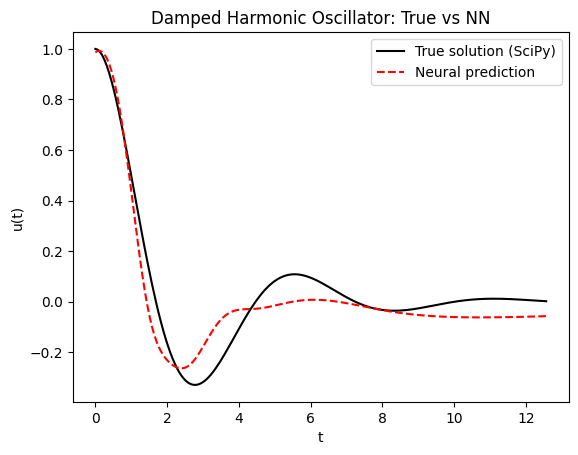

In [13]:
# Testing the model on a *full trajectory* using SciPy as ground truth
u0_test    = 1.0
v0_test    = 0.0
w_test     = 1.2
gamma_test = 0.4

t_grid = np.linspace(0, 4 * np.pi, 200).reshape(-1, 1).astype(np.float32)

# Solve ODE once on the grid to get the true solution
sol = solve_ivp(
    fun=lambda tau, y: damped_rhs(tau, y, gamma_test, w_test),
    t_span=(0.0, float(t_grid[-1, 0])),
    y0=[u0_test, v0_test],
    t_eval=t_grid.flatten(),
    method="RK45",
    rtol=1e-8,
    atol=1e-8,
)
u_true = sol.y[0].reshape(-1, 1).astype(np.float32)

# Build test input for the NN: [u0, v0, w, gamma, t]
X_test = np.hstack([
    np.full_like(t_grid, u0_test),
    np.full_like(t_grid, v0_test),
    np.full_like(t_grid, w_test),
    np.full_like(t_grid, gamma_test),
    t_grid
]).astype(np.float32)

u_pred = model.predict(X_test)

# Plotting the results
plt.plot(t_grid, u_true, 'k-', label='True solution (SciPy)')
plt.plot(t_grid, u_pred, 'r--', label='Neural prediction')
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend()
plt.title("Damped Harmonic Oscillator: True vs NN")
plt.show()

In [14]:
# We can see that the method has failed to accurately capture the dynamics over long time horizons, 
# so we should first see if this would work for just a single case, underdamped for example,

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/616268613.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/616268613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),


Dataset shapes: (60000, 5) (60000, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,353 (392.00 KB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
94/94 - 1s - 12ms/step - loss: 0.1073 - val_loss: 0.0723
Epoch 2/80
94/94 - 0s - 4ms/step - loss: 0.0755 - val_loss: 0.0711
Epoch 3/80
94/94 - 0s - 4ms/step - loss: 0.0722 - val_loss: 0.0662
Epoch 4/80
94/94 - 0s - 4ms/step - loss: 0.0686 - val_loss: 0.0636
Epoch 5/80
94/94 - 0s - 4ms/step - loss: 0.0609 - val_loss: 0.0498
Epoch 6/80
94/94 - 0s - 4ms/step - loss: 0.0469 - val_loss: 0.0325
Epoch 7/80
94/94 - 0s - 4ms/step - loss: 0.0330 - val_loss: 0.0236
Epoch 8/80
94/94 - 0s - 4ms/step - loss: 0.0277 - val_loss: 0.0226
Epoch 9/80
94/94 - 1s - 7ms/step - loss: 0.0253 - val_loss: 0.0202
Epoch 10/80
94/94 - 1s - 7ms/step - loss: 0.0236 - val_loss: 0.0177
Epoch 11/80
94/94 - 1s - 8ms/step - loss: 0.0220 - val_loss: 0.0175
Epoch 12/80
94/94 - 1s - 8ms/step - loss: 0.0214 - val_loss: 0.0163
Epoch 13/80
94/94 - 1s - 8ms/step - loss: 0.0206 - val_loss: 0.0156
Epoch 14/80
94/94 - 1s - 8ms/step - loss: 0.0200 - val_loss: 0.0168
Epoch 15/80
94/94 - 1s - 8ms/step - loss: 0.0195 - val_l

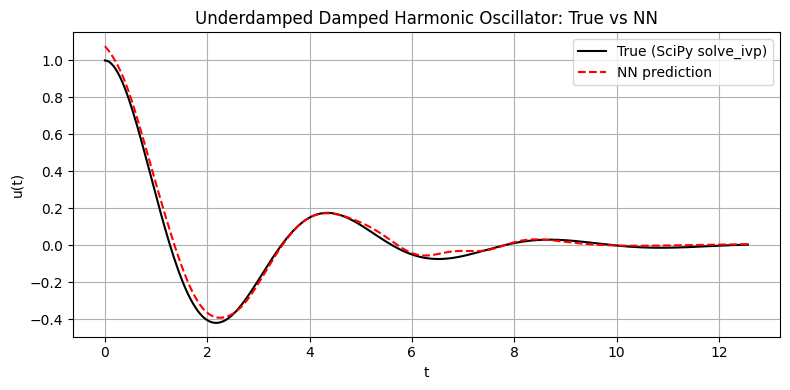

In [15]:
from tensorflow.keras import layers, models, optimizers

# -------------------------
# ODE definition
# -------------------------

def damped_rhs(t, y, gamma, w):
    """
    Right-hand side of the damped oscillator system.
    y = [u, v]
    u' = v
    v' = -2*gamma*v - w^2*u
    """
    u, v = y
    du_dt = v
    dv_dt = -2.0 * gamma * v - (w**2) * u
    return [du_dt, dv_dt]

# -------------------------
# Data generation (single regime: underdamped)
# -------------------------

def make_data_underdamped(
    n_systems=300,      # number of different parameter sets
    num_points=200,     # time points per trajectory
    t_max=4 * np.pi
):
    """
    Generate training data for the underdamped case (gamma < w).

    For each system:
      - sample (u0, v0, w, gamma) with gamma < w,
      - solve the ODE on a fixed time grid,
      - use all (params, t) -> u(t) pairs as training samples.

    Returns:
      X: (n_systems * num_points, 5)  with columns [u0, v0, w, gamma, t_scaled]
      y: (n_systems * num_points, 1)  with u(t)
    """

    # Sample initial conditions
    u0_all = np.random.uniform(-1.5, 1.5, size=(n_systems, 1))
    v0_all = np.random.uniform(-1.0, 1.0, size=(n_systems, 1))

    # Enforce underdamped: gamma < w
    w_all = np.random.uniform(0.8, 2.0, size=(n_systems, 1))          # natural frequency
    gamma_frac = np.random.uniform(0.05, 0.7, size=(n_systems, 1))    # fraction in (0.05, 0.7)
    gamma_all = gamma_frac * w_all                                    # ensures gamma < w

    # Common time grid
    t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

    X_list = []
    y_list = []

    for u0, v0, w, gamma in zip(u0_all, v0_all, w_all, gamma_all):
        # Solve ODE once on the full time grid
        sol = solve_ivp(
            fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),
            t_span=(0.0, float(t_grid[-1, 0])),
            y0=[float(u0), float(v0)],
            t_eval=t_grid.flatten(),
            method="RK45",
            rtol=1e-8,
            atol=1e-8,
        )
        u_traj = sol.y[0].reshape(-1, 1)  # shape (num_points, 1)

        # Build inputs for this trajectory: [u0, v0, w, gamma, t]
        U0 = np.full_like(t_grid, u0)
        V0 = np.full_like(t_grid, v0)
        W  = np.full_like(t_grid, w)
        G  = np.full_like(t_grid, gamma)

        X_traj = np.hstack([U0, V0, W, G, t_grid])  # (num_points, 5)
        y_traj = u_traj                              # (num_points, 1)

        X_list.append(X_traj)
        y_list.append(y_traj)

    X = np.vstack(X_list).astype(np.float32)
    y = np.vstack(y_list).astype(np.float32)

    # Scale t to [0, 1] for nicer optimization (last column)
    X[:, -1] /= t_max

    return X, y, t_max

# -------------------------
# Build & train the model
# -------------------------

# Create dataset for underdamped regime
X, y, T_MAX = make_data_underdamped()

print("Dataset shapes:", X.shape, y.shape)

# Train/validation split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

# Define the neural network model
# Input: [u0, v0, w, gamma, t_scaled]
model = models.Sequential([
    layers.Input(shape=(5,)),
    layers.Dense(256, activation="tanh"),
    layers.Dense(256, activation="tanh"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)  # predict u(t)
])

model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=512,
    verbose=2
)

# -------------------------
# Test on a fresh underdamped system
# -------------------------

u0_test    = 1.0
v0_test    = 0.0
w_test     = 1.5
gamma_test = 0.4     # < w_test ensures underdamped

# True solution from ODE solver
t_grid = np.linspace(0.0, 4 * np.pi, 300).reshape(-1, 1).astype(np.float32)

sol_test = solve_ivp(
    fun=lambda tau, y: damped_rhs(tau, y, gamma_test, w_test),
    t_span=(0.0, float(t_grid[-1, 0])),
    y0=[u0_test, v0_test],
    t_eval=t_grid.flatten(),
    method="RK45",
    rtol=1e-8,
    atol=1e-8,
)
u_true = sol_test.y[0].reshape(-1, 1).astype(np.float32)

# Build NN input: [u0, v0, w, gamma, t_scaled]
t_scaled = t_grid / T_MAX
X_test = np.hstack([
    np.full_like(t_scaled, u0_test),
    np.full_like(t_scaled, v0_test),
    np.full_like(t_scaled, w_test),
    np.full_like(t_scaled, gamma_test),
    t_scaled
]).astype(np.float32)

u_pred = model.predict(X_test)

# -------------------------
# Plot comparison
# -------------------------

plt.figure(figsize=(8, 4))
plt.plot(t_grid, u_true, "k-", label="True (SciPy solve_ivp)")
plt.plot(t_grid, u_pred, "r--", label="NN prediction")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Underdamped Damped Harmonic Oscillator: True vs NN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# We can try to improve this further by using a special activation, sin function, to try to capture oscillatory behavior

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/616268613.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/616268613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),


Dataset shapes: (60000, 5) (60000, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,353 (392.00 KB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
94/94 - 2s - 23ms/step - loss: 0.1020 - val_loss: 0.0486
Epoch 2/80
94/94 - 1s - 7ms/step - loss: 0.0726 - val_loss: 0.0456
Epoch 3/80
94/94 - 1s - 6ms/step - loss: 0.0663 - val_loss: 0.0397
Epoch 4/80
94/94 - 1s - 7ms/step - loss: 0.0572 - val_loss: 0.0337
Epoch 5/80
94/94 - 1s - 7ms/step - loss: 0.0438 - val_loss: 0.0227
Epoch 6/80
94/94 - 1s - 6ms/step - loss: 0.0304 - val_loss: 0.0155
Epoch 7/80
94/94 - 1s - 7ms/step - loss: 0.0244 - val_loss: 0.0135
Epoch 8/80
94/94 - 1s - 6ms/step - loss: 0.0226 - val_loss: 0.0129
Epoch 9/80
94/94 - 1s - 9ms/step - loss: 0.0207 - val_loss: 0.0126
Epoch 10/80
94/94 - 1s - 10ms/step - loss: 0.0194 - val_loss: 0.0115
Epoch 11/80
94/94 - 1s - 8ms/step - loss: 0.0181 - val_loss: 0.0120
Epoch 12/80
94/94 - 1s - 7ms/step - loss: 0.0167 - val_loss: 0.0095
Epoch 13/80
94/94 - 1s - 7ms/step - loss: 0.0154 - val_loss: 0.0094
Epoch 14/80
94/94 - 1s - 7ms/step - loss: 0.0149 - val_loss: 0.0088
Epoch 15/80
94/94 - 1s - 7ms/step - loss: 0.0140 - val_

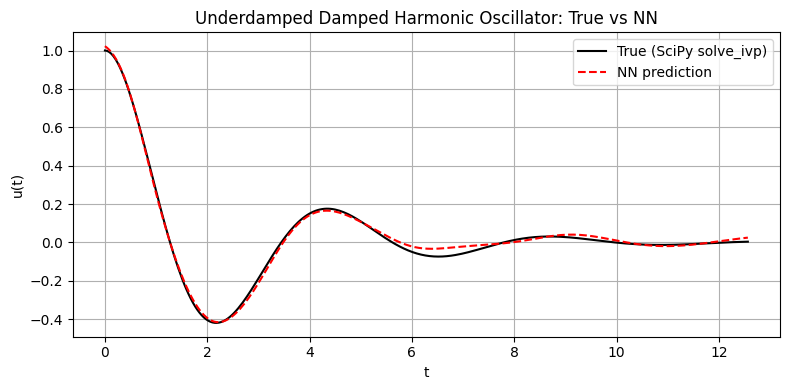

In [17]:
# Create dataset for underdamped regime
X, y, T_MAX = make_data_underdamped()

print("Dataset shapes:", X.shape, y.shape)

# Train/validation split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

# Define the neural network model
# Input: [u0, v0, w, gamma, t_scaled]
model = models.Sequential([
    layers.Input(shape=(5,)),
    layers.Dense(256, activation="tanh"),
    layers.Dense(256, activation=sin_activation),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)  # predict u(t)
])

model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=512,
    verbose=2
)

# -------------------------
# Test on a fresh underdamped system
# -------------------------

u0_test    = 1.0
v0_test    = 0.0
w_test     = 1.5
gamma_test = 0.4     # < w_test ensures underdamped

# True solution from ODE solver
t_grid = np.linspace(0.0, 4 * np.pi, 300).reshape(-1, 1).astype(np.float32)

sol_test = solve_ivp(
    fun=lambda tau, y: damped_rhs(tau, y, gamma_test, w_test),
    t_span=(0.0, float(t_grid[-1, 0])),
    y0=[u0_test, v0_test],
    t_eval=t_grid.flatten(),
    method="RK45",
    rtol=1e-8,
    atol=1e-8,
)
u_true = sol_test.y[0].reshape(-1, 1).astype(np.float32)

# Build NN input: [u0, v0, w, gamma, t_scaled]
t_scaled = t_grid / T_MAX
X_test = np.hstack([
    np.full_like(t_scaled, u0_test),
    np.full_like(t_scaled, v0_test),
    np.full_like(t_scaled, w_test),
    np.full_like(t_scaled, gamma_test),
    t_scaled
]).astype(np.float32)

u_pred = model.predict(X_test)

# -------------------------
# Plot comparison
# -------------------------

plt.figure(figsize=(8, 4))
plt.plot(t_grid, u_true, "k-", label="True (SciPy solve_ivp)")
plt.plot(t_grid, u_pred, "r--", label="NN prediction")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Underdamped Damped Harmonic Oscillator: True vs NN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# We find that the combination model works better than the plain tanh model

In [19]:
# We will now attempt this logic with the overdamped case of the harmonic oscillator,
# ie gamma > w

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/1944781372.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/1944781372.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),


Dataset shapes: (60000, 5) (60000, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,353 (392.00 KB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
94/94 - 1s - 13ms/step - loss: 0.0994 - val_loss: 0.0311
Epoch 2/80
94/94 - 0s - 5ms/step - loss: 0.0172 - val_loss: 0.0058
Epoch 3/80
94/94 - 1s - 7ms/step - loss: 0.0063 - val_loss: 0.0034
Epoch 4/80
94/94 - 1s - 6ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 5/80
94/94 - 1s - 6ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/80
94/94 - 1s - 6ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 7/80
94/94 - 1s - 8ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 8/80
94/94 - 1s - 8ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/80
94/94 - 1s - 7ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 10/80
94/94 - 1s - 7ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 11/80
94/94 - 1s - 7ms/step - loss: 0.0016 - val_loss: 9.2931e-04
Epoch 12/80
94/94 - 1s - 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 13/80
94/94 - 1s - 5ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 14/80
94/94 - 1s - 6ms/step - loss: 0.0013 - val_loss: 9.9725e-04
Epoch 15/80
94/94 - 1s - 6ms/step - loss: 0.0012

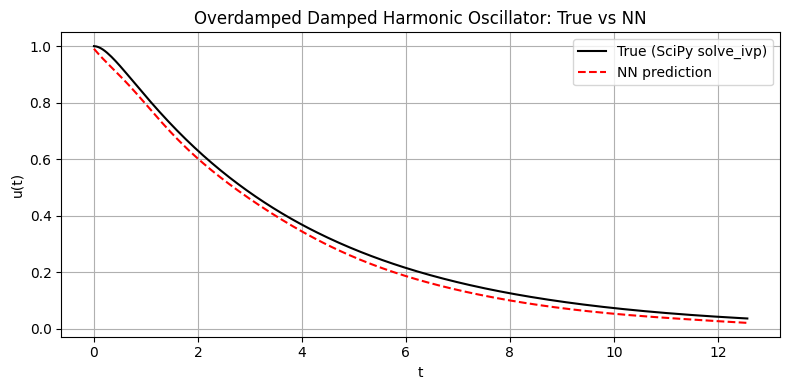

In [20]:
def make_data_overdamped(
    n_systems=300,      # number of different parameter sets
    num_points=200,     # time points per trajectory
    t_max=4 * np.pi
):

    # Sample initial conditions
    u0_all = np.random.uniform(-1.5, 1.5, size=(n_systems, 1))
    v0_all = np.random.uniform(-1.0, 1.0, size=(n_systems, 1))

    # Enforce overdamped: gamma > w
    # Choose a moderate w, then make gamma a factor > 1 times w
    w_all = np.random.uniform(0.5, 1.5, size=(n_systems, 1))         # natural frequency
    factor = np.random.uniform(1.3, 2.5, size=(n_systems, 1))        # > 1
    gamma_all = factor * w_all                                       # ensures gamma > w

    # Common time grid
    t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

    X_list = []
    y_list = []

    for u0, v0, w, gamma in zip(u0_all, v0_all, w_all, gamma_all):
        # Solve ODE once on the full time grid
        sol = solve_ivp(
            fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),
            t_span=(0.0, float(t_grid[-1, 0])),
            y0=[float(u0), float(v0)],
            t_eval=t_grid.flatten(),
            method="RK45",
            rtol=1e-8,
            atol=1e-8,
        )
        u_traj = sol.y[0].reshape(-1, 1)  # shape (num_points, 1)

        # Build inputs for this trajectory: [u0, v0, w, gamma, t]
        U0 = np.full_like(t_grid, u0)
        V0 = np.full_like(t_grid, v0)
        W  = np.full_like(t_grid, w)
        G  = np.full_like(t_grid, gamma)

        X_traj = np.hstack([U0, V0, W, G, t_grid])
        y_traj = u_traj

        X_list.append(X_traj)
        y_list.append(y_traj)

    X = np.vstack(X_list).astype(np.float32)
    y = np.vstack(y_list).astype(np.float32)

    # Scale t to [0, 1] for nicer optimization (last column)
    X[:, -1] /= t_max

    return X, y, t_max

# -------------------------
# Build & train the model
# -------------------------

# Create dataset for overdamped regime
X, y, T_MAX = make_data_overdamped()

print("Dataset shapes:", X.shape, y.shape)

# Train/validation split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

# Define the neural network model
# Input: [u0, v0, w, gamma, t_scaled]
# For overdamped (non-oscillatory) you can actually drop sin and use pure tanh,
# but I'll show both variants. Comment/uncomment what you prefer.

USE_SIN_LAYER = True

if USE_SIN_LAYER:
    model = models.Sequential([
        layers.Input(shape=(5,)),
        layers.Dense(256, activation="tanh"),
        layers.Dense(256, activation=sin_activation),    # still fine, just not essential
        layers.Dense(128, activation="tanh"),
        layers.Dense(1)
    ])
else:
    model = models.Sequential([
        layers.Input(shape=(5,)),
        layers.Dense(256, activation="tanh"),
        layers.Dense(256, activation="tanh"),
        layers.Dense(128, activation="tanh"),
        layers.Dense(1)
    ])

model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=512,
    verbose=2
)

# -------------------------
# Test on a fresh overdamped system
# -------------------------

u0_test    = 1.0
v0_test    = 0.0
w_test     = 1.0
gamma_test = 2.0    # > w_test → overdamped

# True solution from ODE solver
t_grid = np.linspace(0.0, 4 * np.pi, 300).reshape(-1, 1).astype(np.float32)

sol_test = solve_ivp(
    fun=lambda tau, y: damped_rhs(tau, y, gamma_test, w_test),
    t_span=(0.0, float(t_grid[-1, 0])),
    y0=[u0_test, v0_test],
    t_eval=t_grid.flatten(),
    method="RK45",
    rtol=1e-8,
    atol=1e-8,
)
u_true = sol_test.y[0].reshape(-1, 1).astype(np.float32)

# Build NN input: [u0, v0, w, gamma, t_scaled]
t_scaled = t_grid / T_MAX
X_test = np.hstack([
    np.full_like(t_scaled, u0_test),
    np.full_like(t_scaled, v0_test),
    np.full_like(t_scaled, w_test),
    np.full_like(t_scaled, gamma_test),
    t_scaled
]).astype(np.float32)

u_pred = model.predict(X_test)

# -------------------------
# Plot comparison
# -------------------------

plt.figure(figsize=(8, 4))
plt.plot(t_grid, u_true, "k-", label="True (SciPy solve_ivp)")
plt.plot(t_grid, u_pred, "r--", label="NN prediction")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Overdamped Damped Harmonic Oscillator: True vs NN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# We will finally try the critically damped case, gamma = w

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/1423571108.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78172/1423571108.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),


Dataset shapes (critical): (60000, 5) (60000, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,353 (392.00 KB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
94/94 - 2s - 19ms/step - loss: 0.0642 - val_loss: 0.0399
Epoch 2/80
94/94 - 1s - 13ms/step - loss: 0.0256 - val_loss: 0.0176
Epoch 3/80
94/94 - 1s - 13ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 4/80
94/94 - 1s - 13ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/80
94/94 - 1s - 11ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/80
94/94 - 1s - 11ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/80
94/94 - 1s - 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/80
94/94 - 1s - 9ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/80
94/94 - 1s - 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/80
94/94 - 1s - 8ms/step - loss: 0.0010 - val_loss: 9.9107e-04
Epoch 11/80
94/94 - 1s - 7ms/step - loss: 0.0011 - val_loss: 9.5032e-04
Epoch 12/80
94/94 - 1s - 7ms/step - loss: 8.6278e-04 - val_loss: 0.0011
Epoch 13/80
94/94 - 1s - 10ms/step - loss: 9.2405e-04 - val_loss: 8.8770e-04
Epoch 14/80
94/94 - 1s - 6ms/step - loss: 7.2931e-04 - val_loss: 6.8927e-04
Epoch 15/80
94/94 - 1

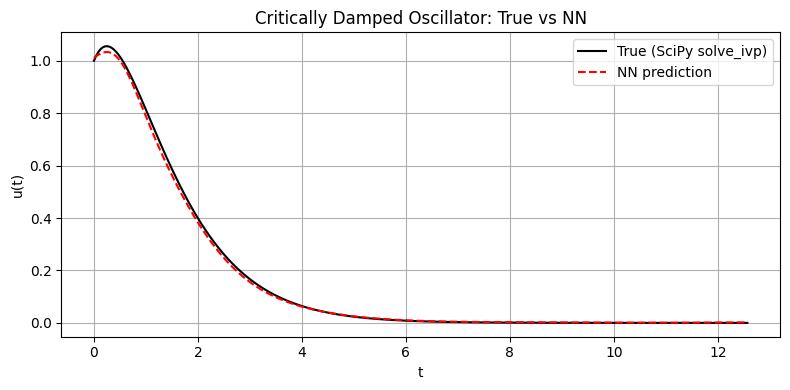

In [22]:
def make_data_critical(
    n_systems=300,      # number of different parameter sets
    num_points=200,     # time points per trajectory
    t_max=4 * np.pi
):
    """
    Generate training data for the critically damped case (gamma = w).

    For each system:
      - sample (u0, v0, w) and set gamma = w,
      - solve the ODE on a fixed time grid,
      - use all (params, t) -> u(t) pairs as training samples.

    Returns:
      X: (n_systems * num_points, 5)  with columns [u0, v0, w, gamma, t_scaled]
      y: (n_systems * num_points, 1)  with u(t)
      t_max: scalar, used for rescaling t in test
    """

    # Sample initial conditions
    u0_all = np.random.uniform(-1.5, 1.5, size=(n_systems, 1))
    v0_all = np.random.uniform(-1.0, 1.0, size=(n_systems, 1))

    # Critical: gamma = w
    w_all = np.random.uniform(0.8, 2.0, size=(n_systems, 1))
    gamma_all = w_all.copy()   # exactly critical

    # Common time grid
    t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

    X_list = []
    y_list = []

    for u0, v0, w, gamma in zip(u0_all, v0_all, w_all, gamma_all):
        # Solve ODE once on the full time grid
        sol = solve_ivp(
            fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),
            t_span=(0.0, float(t_grid[-1, 0])),
            y0=[float(u0), float(v0)],
            t_eval=t_grid.flatten(),
            method="RK45",
            rtol=1e-8,
            atol=1e-8,
        )
        u_traj = sol.y[0].reshape(-1, 1)  # shape (num_points, 1)

        # Build inputs for this trajectory: [u0, v0, w, gamma, t]
        U0 = np.full_like(t_grid, u0)
        V0 = np.full_like(t_grid, v0)
        W  = np.full_like(t_grid, w)
        G  = np.full_like(t_grid, gamma)

        X_traj = np.hstack([U0, V0, W, G, t_grid])
        y_traj = u_traj

        X_list.append(X_traj)
        y_list.append(y_traj)

    X = np.vstack(X_list).astype(np.float32)
    y = np.vstack(y_list).astype(np.float32)

    # Scale t to [0, 1] for nicer optimization (last column)
    X[:, -1] /= t_max

    return X, y, t_max

# -------------------------
# Build & train the model
# -------------------------

# Create dataset for critical regime
X, y, T_MAX = make_data_critical()

print("Dataset shapes (critical):", X.shape, y.shape)

# Train/validation split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

# Model: we can reuse the tanh + sin hybrid that worked well
model = models.Sequential([
    layers.Input(shape=(5,)),          # [u0, v0, w, gamma, t_scaled]
    layers.Dense(256, activation="tanh"),
    layers.Dense(256, activation=sin_activation),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)
])

model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=512,
    verbose=2
)

# -------------------------
# Test on a fresh critical system
# -------------------------

u0_test    = 1.0
v0_test    = 0.5
w_test     = 1.2
gamma_test = w_test    # critical: gamma = w

# True solution from ODE solver
t_grid = np.linspace(0.0, 4 * np.pi, 300).reshape(-1, 1).astype(np.float32)

sol_test = solve_ivp(
    fun=lambda tau, y: damped_rhs(tau, y, gamma_test, w_test),
    t_span=(0.0, float(t_grid[-1, 0])),
    y0=[u0_test, v0_test],
    t_eval=t_grid.flatten(),
    method="RK45",
    rtol=1e-8,
    atol=1e-8,
)
u_true = sol_test.y[0].reshape(-1, 1).astype(np.float32)

# Build NN input: [u0, v0, w, gamma, t_scaled]
t_scaled = t_grid / T_MAX
X_test = np.hstack([
    np.full_like(t_scaled, u0_test),
    np.full_like(t_scaled, v0_test),
    np.full_like(t_scaled, w_test),
    np.full_like(t_scaled, gamma_test),
    t_scaled
]).astype(np.float32)

u_pred = model.predict(X_test)

# -------------------------
# Plot comparison
# -------------------------

plt.figure(figsize=(8, 4))
plt.plot(t_grid, u_true, "k-", label="True (SciPy solve_ivp)")
plt.plot(t_grid, u_pred, "r--", label="NN prediction")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Critically Damped Oscillator: True vs NN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()